# Converting from fo2 to buffer position
- You can download the spreadsheet here: https://github.com/PennyWieser/Thermobar/blob/main/docs/Examples/Other_features/Redox_Conversions.xlsx

In [6]:
# Loading various python things
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Thermobar as pt

## Pichavent experimental data
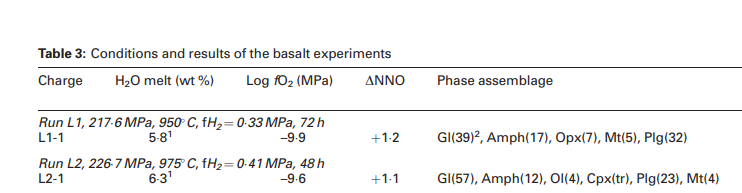

In [52]:
# Say its really in MPa
logfo2_MPa=-9.9
fo2_MPa=10**(logfo2_MPa)
fo2_bar=10*fo2_MPa
convert_fo2_to_buffer(fo2=fo2_bar, 
                      T_K=950+273.15, P_kbar=217.6/100)

,deltaNNO_Frost1991,deltaQFM_Frost1991,QFM_equation_Choice,T_K,P_kbar,fo2
0,2.040004,2.68716,High T,1223.15,2.176,1.258925e-09


In [54]:
# Say its really in bars
logfo2_MPa=-9.9
fo2_MPa=10**(logfo2_MPa)
fo2_bar=fo2_MPa
convert_fo2_to_buffer(fo2=fo2_bar, 
                      T_K=950+273.15, P_kbar=217.6/100)

,deltaNNO_Frost1991,deltaQFM_Frost1991,QFM_equation_Choice,T_K,P_kbar,fo2
0,1.040004,1.68716,High T,1223.15,2.176,1.258925e-10


## Load in data
- No suffix in file, so add here to say they are liquids

In [16]:
load=pt.import_excel('Redox_Conversions.xlsx', sheet_name="Pichavent_2018")
Liqs=load['Liqs']
myinput=load['my_input']
myinput.head()

,Experiment,Phase,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Total,P_kbar,T_K,DeltaNNO,logfo2_MPa,fo2_Mpa,fo2_bars
0,SG13,Gl,72.6,0.28,14.7,2.89,0.89,3.99,2.79,1.85,92,2.04,1073.15,0.6,-13.8,1.584893e-14,1.584893e-13


In [36]:
convert_fo2_to_buffer(fo2=myinput['fo2_Mpa'], 
                      T_K=myinput['T_K'], P_kbar=myinput['P_kbar'])

,deltaNNO_Frost1991,deltaQFM_Frost1991,QFM_equation_Choice,T_K,P_kbar,fo2
0,-0.016725,0.641639,High T,1073.15,2.04,1.584893e-14


In [33]:

convert_fo2_to_buffer(fo2=myinput['fo2_bars'], 
                      T_K=myinput['T_K'], P_kbar=myinput['P_kbar'])

,deltaNNO_Frost1991,deltaQFM_Frost1991,QFM_equation_Choice,T_K,P_kbar,fo2
0,0.983275,1.641639,High T,1073.15,2.04,1.584893e-13


In [48]:
def convert_fo2_to_buffer(fo2=None, T_K=None, P_kbar=None):
    
    """ Converts fo2 in bars to deltaNNO and delta QFM using Frost 1991 
    based on user-entered T in Kelvin and P in kbar
    """
    logfo2=np.log10(fo2)
# NNO Buffer position from frost (1991)
    logfo2_NNO=(-24930/T_K) + 9.36 + 0.046 * ((P_kbar*1000)-1)/T_K

    fo2_NNO=10**logfo2
    DeltaNNO=logfo2-logfo2_NNO
    


#  QFM Buffer position from frost (1991)

    # Calculates cut off T for alpha-beta qtz transition that determins QFM
    Cut_off_T=573+273.15+0.025*(P_kbar*1000)
    
    logfo2_QFM_highT=(-25096.3/T_K) + 8.735 + 0.11 * ((P_kbar*1000)-1)/T_K
    T_Choice='HighT Beta Qtz'

    logfo2_QFM_lowT=(-26455.3/T_K) +10.344 + 0.092 * ((P_kbar*1000)-1)/T_K
    T_Choice='Low T alpha Qtz'

        
    fo2_QFM_highT=10**logfo2_QFM_highT
    fo2_QFM_lowT=10**logfo2_QFM_lowT

    Delta_QFM_highT=logfo2-logfo2_QFM_highT
    Delta_QFM_lowT=logfo2-logfo2_QFM_highT   
    if isinstance(fo2, float) or isinstance(fo2, int):
        if T_K<Cut_off_T:
            DeltaQFM=Delta_QFM_lowT
        if T_K>=Cut_off_T:
            DeltaQFM=Delta_QFM_highT
        out=pd.DataFrame(data={'deltaNNO_Frost1991':  DeltaNNO,
                               'deltaQFM_Frost1991':  DeltaQFM,
                               'QFM_equation_Choice': 'High T',
                               'T_K': T_K,
                               'P_kbar': P_kbar,
                               'fo2': fo2}, index=[0])
    else:
        out=pd.DataFrame(data={'deltaNNO_Frost1991':  DeltaNNO,
                               'deltaQFM_Frost1991': Delta_QFM_highT,
                               'QFM_equation_Choice': 'High T',
                               'T_K': T_K,
                               'P_kbar': P_kbar,
                               'fo2': fo2}) 
        out.loc[(T_K<Cut_off_T), 'deltaQFM_Frost1991']=Delta_QFM_lowT
        out.loc[(T_K<Cut_off_T), 'QFM_equation_Choice']='Low T'
    
    return out
                           
                           
                           

## Example 1: Calculating Fe3Fet for a series of liquid compositions
- Remember, Fe3Fet_Liq to buffer positions is very dependent on temperature, so first we need to choose a thermometer

In [16]:
# Calculate temperature
T_HT87=pt.calculate_liq_only_temp(liq_comps=Liqs, equationT='T_Helz1987_MgO')

### 1a: Using a value for logfo2

In [5]:
logfo2=-13.2

# Calculate oxides using Kress 1991 and 3 kbar, and 
myLiquids_Fe3_Kress_norm=pt.convert_fo2_to_fe_partition(liq_comps=Liqs, T_K=800+273.15, 
                            P_kbar=3, fo2=10**logfo2, model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm.head()

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq
0,51.524017,2.605133,13.546977,3.774733,7.730924,0.186119,6.707341,10.989132,2.410111,0.484441,0.248864,0.305237
1,51.535177,2.645197,13.736989,3.780389,7.788015,0.189839,6.507155,10.829918,2.454594,0.494123,0.253838,0.303996
2,51.575604,2.775984,13.689274,3.864310,8.061706,0.200831,6.285636,10.477006,2.513328,0.521354,0.268537,0.301340
3,51.600593,2.878059,13.594286,3.933036,8.275994,0.209284,6.149388,10.236264,2.548374,0.542061,0.279838,0.299531
4,51.614175,3.065335,13.378208,4.052142,8.592254,0.224249,5.869192,9.998340,2.598055,0.578352,0.299848,0.297925


Text(0, 0.5, 'Fe3Fet Liq')

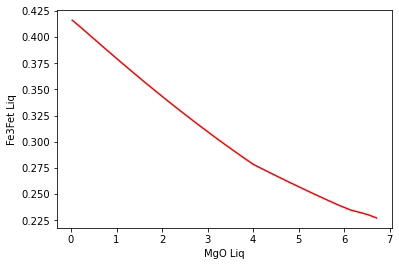

In [19]:
plt.plot(myLiquids_Fe3_Kress_norm['MgO_Liq'], myLiquids_Fe3_Kress_norm['Fe3Fet_Liq'], '-r')
plt.xlabel('MgO Liq')
plt.ylabel('Fe3Fet Liq')

### 1b: At a known buffer (here, QFM)

In [21]:
# Calculate oxides using Kress 1991 and 3 kbar, and 
myLiquids_Fe3_Kress_norm_QFM=pt.convert_fo2_to_fe_partition(liq_comps=Liqs, T_K=T_HT87, 
                            P_kbar=3, fo2="QFM", model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_QFM.head()

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq
0,51.621424,2.610058,13.572588,1.881698,9.456264,0.186471,6.720022,11.009907,2.414668,0.485357,0.249335,0.151860
1,51.632661,2.650201,13.762974,1.886144,9.514574,0.190198,6.519464,10.850404,2.459237,0.495057,0.254318,0.151373
2,51.675308,2.781350,13.715738,1.928249,9.827054,0.201220,6.297788,10.497260,2.518187,0.522361,0.269056,0.150063
3,51.702115,2.883721,13.621032,1.962512,10.073308,0.209695,6.161487,10.256404,2.553387,0.543127,0.280389,0.149155
4,51.718628,3.071538,13.405281,2.025025,10.442040,0.224702,5.881070,10.018574,2.603312,0.579522,0.300455,0.148573


Text(0, 0.5, 'Fe3Fet Liq')

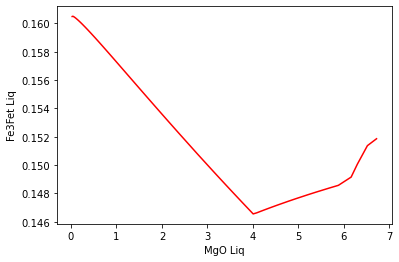

In [22]:
plt.plot(myLiquids_Fe3_Kress_norm_QFM['MgO_Liq'], myLiquids_Fe3_Kress_norm_QFM['Fe3Fet_Liq'], '-r')
plt.xlabel('MgO Liq')
plt.ylabel('Fe3Fet Liq')

### 1c: At buffer with offset (here NNO+1)

In [24]:
# Calculate oxides using Kress 1991 and 3 kbar, and 
myLiquids_Fe3_Kress_norm_NNO1=pt.convert_fo2_to_fe_partition(liq_comps=Liqs, T_K=T_HT87, 
                            P_kbar=3, fo2="NNO", fo2_offset=1, model="Kress1991", renorm=True)
myLiquids_Fe3_Kress_norm_NNO1.head()

,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq
0,51.546390,2.606264,13.552860,3.339932,8.127207,0.186200,6.710254,10.993904,2.411158,0.484651,0.248972,0.269955
1,51.557365,2.646336,13.742904,3.349248,8.180990,0.189920,6.509957,10.834581,2.455651,0.494335,0.253947,0.269205
2,51.598076,2.777193,13.695239,3.427946,8.459594,0.200919,6.288375,10.481571,2.514423,0.521581,0.268654,0.267191
3,51.623335,2.879327,13.600278,3.491627,8.678603,0.209376,6.152098,10.240776,2.549497,0.542300,0.279962,0.265793
4,51.637241,3.066705,13.384186,3.604510,9.000728,0.224349,5.871815,10.002808,2.599216,0.578610,0.299982,0.264891


Text(0, 0.5, 'Fe3Fet Liq')

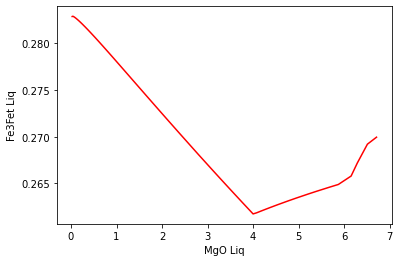

In [25]:
plt.plot(myLiquids_Fe3_Kress_norm_NNO1['MgO_Liq'], myLiquids_Fe3_Kress_norm_NNO1['Fe3Fet_Liq'], '-r')
plt.xlabel('MgO Liq')
plt.ylabel('Fe3Fet Liq')

### 1d: With different normalization routines:
- So far, we used Norm=True, this renormalizes the other oxides to account for the changing FeO and Fe2O3 amount, can also put false, doesn't affect the Fe3FeT but affects the oxide concs.  You can see this by comparing the other oxide contents

In [29]:
logfo2=-7.58429552677443
print('Original')
display(Liqs.loc[[0]])

# No renormalizatoin
myLiquids_Fe3_Kress_nonorm=pt.convert_fo2_to_fe_partition(liq_comps=Liqs.loc[[0]], T_K=T_HT87.loc[[0]], 
                            P_kbar=3, fo2=10**logfo2, model="Kress1991", renorm=False)
print('No Norm')
display(myLiquids_Fe3_Kress_nonorm)


# With renormalization 
myLiquids_Fe3_Kress_norm=pt.convert_fo2_to_fe_partition(liq_comps=Liqs.loc[[0]], T_K=T_HT87.loc[[0]], 
                            P_kbar=3, fo2=10**logfo2, model="Kress1991", renorm=True)
print('Renorm')
display(myLiquids_Fe3_Kress_norm)


Original


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq
0,51.456179,2.60169,13.529073,11.11461,0.185873,6.698477,10.974609,2.406926,0.483801,0.0,0.248535,0.508277,0.0,0.0,0.0,0.0,0


No Norm


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,Cr2O3_Liq,P2O5_Liq,H2O_Liq,Fe3Fet_Liq,NiO_Liq,CoO_Liq,CO2_Liq,Sample_ID_Liq,FeO_Liq,Fe2O3_Liq,XFe3Fe2
0,51.456179,2.60169,13.529073,11.11461,0.185873,6.698477,10.974609,2.406926,0.483801,0.0,0.248535,0.508277,0.227286,0.0,0.0,0.0,0,8.589075,2.807726,0.147152


Renorm


,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq
0,51.573474,2.607633,13.559981,2.813568,8.606944,0.186298,6.71378,10.99968,2.412425,0.484906,0.249103,0.227286


## Converting from FeO and Fe2O3 proportions to fo2
- This function goes the other way, it takes a liquid with FeO and Fe2O3, and a temperature and pressure, and converts to a buffer position/delta fo2 vlaue

In [41]:
## The inversion isn't quite perfect, but is very close
calc_fo2=pt.convert_fe_partition_to_fo2(liq_comps=myLiquids_Fe3_Kress_norm_NNO1,
                                        T_K=T_HT87, P_kbar=3, model="Kress1991", renorm=False)

In [42]:
calc_fo2

,DeltaQFM,DeltaNNO,fo2_calc,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Fe2O3_Liq,FeO_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,Fe3Fet_Liq
0,1.587252,0.980283,7.999607e-08,51.546390,2.606264,13.552860,3.339932,8.127207,0.186200,6.710254,10.993904,2.411158,0.484651,0.248972,0.269955
1,1.587349,0.980431,7.139051e-08,51.557365,2.646336,13.742904,3.349248,8.180990,0.189920,6.509957,10.834581,2.455651,0.494335,0.253947,0.269205
2,1.587300,0.980439,6.284887e-08,51.598076,2.777193,13.695239,3.427946,8.459594,0.200919,6.288375,10.481571,2.514423,0.521581,0.268654,0.267191
3,1.587231,0.980406,5.807824e-08,51.623335,2.879327,13.600278,3.491627,8.678603,0.209376,6.152098,10.240776,2.549497,0.542300,0.279962,0.265793
4,1.586615,0.979863,4.928451e-08,51.637241,3.066705,13.384186,3.604510,9.000728,0.224349,5.871815,10.002808,2.599216,0.578610,0.299982,0.264891
5,1.586086,0.979386,4.382653e-08,51.638351,3.199578,13.221434,3.682642,9.209909,0.234892,5.673066,9.879096,2.629078,0.603989,0.314080,0.264593
6,1.585330,0.978706,3.698529e-08,51.634502,3.398218,12.978289,3.796698,9.516734,0.250723,5.387579,9.701648,2.668614,0.641860,0.335248,0.264151
7,1.584851,0.978275,3.316046e-08,51.628396,3.530278,12.816809,3.870774,9.716984,0.261292,5.205129,9.588480,2.691642,0.666987,0.349380,0.263860
8,1.584167,0.977661,2.831006e-08,51.614145,3.727939,12.575476,3.979141,10.011395,0.277175,4.942417,9.425986,2.721464,0.704516,0.370618,0.263425
9,1.583734,0.977274,2.556757e-08,51.601373,3.859495,12.415173,4.049654,10.203931,0.287788,4.774137,9.322264,2.738345,0.729436,0.384809,0.263138
